
# Зниження розмірності та візуалізація (PCA & t‑SNE) + класифікація (kNN)

**Мета:** порівняти якість і час навчання класифікатора k‑Nearest Neighbors на:
1) початкових ознаках,  
2) після `PCA(n_components=0.95)`,  
3) на 2‑компонентному `PCA(n_components=2)` (для порівняння з 2D),  
а також побудувати 2D-візуалізації через `PCA(2)` і `t-SNE(2)`.


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PATH = Path('breast-cancer.csv')
df = pd.read_csv(DATA_PATH)
df.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# Визначаємо цільову змінну (бінарну)

# Визначаємо цільову змінну (бінарну)
target_col = "diagnosis"

y_raw = df[target_col].astype(str)

# Мапінг до {0,1} для строкових міток
uniq = sorted(y_raw.dropna().unique().tolist())
lowered = [str(v).lower() for v in uniq]

if set(lowered) >= set(["b","m"]):
    mapping = {"B":0,"M":1,"b":0,"m":1}
elif set(lowered) >= set(["benign","malignant"]):
    mapping = {"benign":0,"malignant":1}
else:
    raise ValueError("Не вдалося знайти очікувані мітки ('B/M' або 'benign/malignant').")

y = y_raw.map(mapping).astype(int)

X = df.drop(columns=[target_col]).select_dtypes(include=[np.number]).copy()

if X.shape[1] == 0:
    raise ValueError("Не знайдено числових ознак після видалення target.")

X.shape, y.shape, mapping



((569, 31), (569,), {'B': 0, 'M': 1, 'b': 0, 'm': 1})

In [4]:
# 2) Трейн/тест спліт, масштабування та базова модель (kNN)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

def fit_and_evaluate(pipeline, X_train, y_train, X_test, y_test, note=''):
    t0 = time.perf_counter()
    pipeline.fit(X_train, y_train)
    train_time = time.perf_counter() - t0
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return {
        'setup': note,
        'accuracy': acc,
        'train_time_sec': train_time,
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
        'report': classification_report(y_test, y_pred, output_dict=False)
    }

# Базова модель на початкових ознаках
base_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

base_res = fit_and_evaluate(base_clf, X_train, y_train, X_test, y_test, note='Raw features + kNN(k=5)')
print(base_res['setup'], '\nAccuracy:', base_res['accuracy'], '\nTrain time (s):', base_res['train_time_sec'])
print('Confusion matrix:\n', np.array(base_res['confusion_matrix']))
print('\nClassification report:\n', base_res['report'])


Raw features + kNN(k=5) 
Accuracy: 0.958041958041958 
Train time (s): 0.009899998999799209
Confusion matrix:
 [[89  1]
 [ 5 48]]

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97        90
           1       0.98      0.91      0.94        53

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



In [5]:
# 3) PCA: 95% дисперсії та рівно 2 компоненти

from sklearn.decomposition import PCA

# PCA на 95% дисперсії (підбір k за поясненою дисперсією)
pca95_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=RANDOM_STATE)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

pca95_res = fit_and_evaluate(pca95_clf, X_train, y_train, X_test, y_test, note='PCA(0.95) + kNN(k=5)')
print(pca95_res['setup'], '\nAccuracy:', pca95_res['accuracy'], '\nTrain time (s):', pca95_res['train_time_sec'])
print('Confusion matrix:\n', np.array(pca95_res['confusion_matrix']))

# PCA з 2 компонентами (для порівняння з 2D)
pca2_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2, random_state=RANDOM_STATE)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

pca2_res = fit_and_evaluate(pca2_clf, X_train, y_train, X_test, y_test, note='PCA(2) + kNN(k=5)')
print(pca2_res['setup'], '\nAccuracy:', pca2_res['accuracy'], '\nTrain time (s):', pca2_res['train_time_sec'])
print('Confusion matrix:\n', np.array(pca2_res['confusion_matrix']))


PCA(0.95) + kNN(k=5) 
Accuracy: 0.958041958041958 
Train time (s): 0.021500000000060027
Confusion matrix:
 [[89  1]
 [ 5 48]]
PCA(2) + kNN(k=5) 
Accuracy: 0.9370629370629371 
Train time (s): 0.010599998999850868
Confusion matrix:
 [[88  2]
 [ 7 46]]


Matplotlib is building the font cache; this may take a moment.


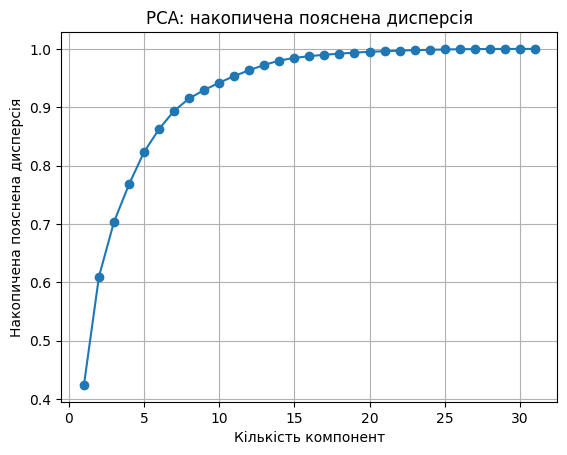

In [6]:
# Крива поясненої дисперсії для PCA

import matplotlib.pyplot as plt

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca_full = PCA().fit(X_train_scaled)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure()
plt.plot(range(1, len(cumvar)+1), cumvar, marker='o')
plt.xlabel('Кількість компонент')
plt.ylabel('Накопичена пояснена дисперсія')
plt.title('PCA: накопичена пояснена дисперсія')
plt.grid(True)
plt.show()


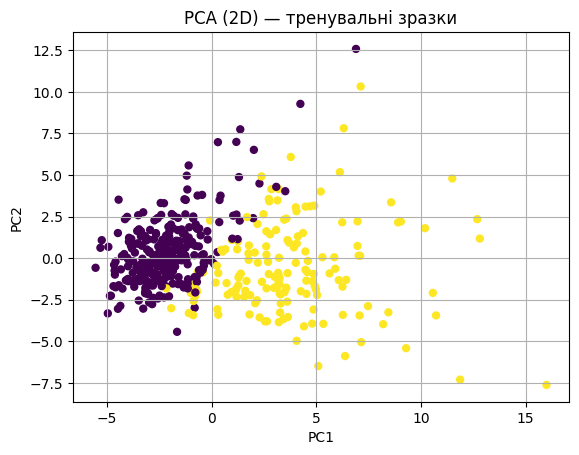

In [7]:
#  4) Візуалізація: PCA (2 компоненти)

X_pca2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X_train_scaled)
plt.figure()
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y_train, s=25)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA (2D) — тренувальні зразки')
plt.grid(True)
plt.show()


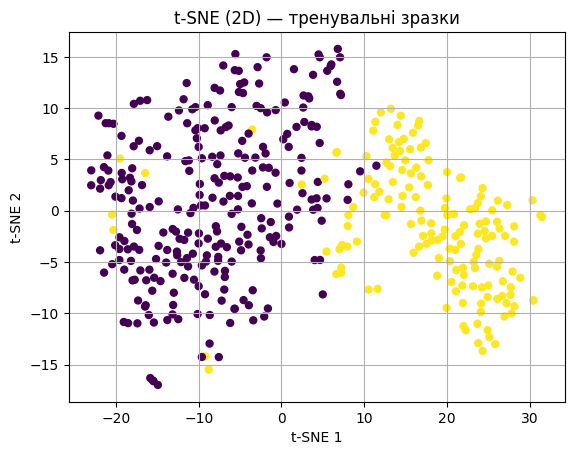

In [8]:
# 5) Візуалізація: t-SNE (2 компоненти)
# t-SNE — інструмент для візуалізації, а не для навчання класифікатора.
# Параметри t-SNE (perplexity, learning_rate) наведені типовi

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, learning_rate='auto', init='pca')
X_tsne2 = tsne.fit_transform(X_train_scaled)

plt.figure()
plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c=y_train, s=25)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE (2D) — тренувальні зразки')
plt.grid(True)
plt.show()


In [10]:

# %% [markdown]
# ## 7) Порівняння результатів

import pandas as pd
summary = pd.DataFrame([
    {'Setup': base_res['setup'], 'Accuracy': base_res['accuracy'], 'Train time (s)': base_res['train_time_sec']},
    {'Setup': pca95_res['setup'], 'Accuracy': pca95_res['accuracy'], 'Train time (s)': pca95_res['train_time_sec']},
    {'Setup': pca2_res['setup'], 'Accuracy': pca2_res['accuracy'], 'Train time (s)': pca2_res['train_time_sec']},
])
summary


,Setup,Accuracy,Train time (s)
0,Raw features + kNN(k=5),0.958042,0.0099
1,PCA(0.95) + kNN(k=5),0.958042,0.0215
2,PCA(2) + kNN(k=5),0.937063,0.0106



## Висновки (шаблон — відредагуйте під свої числа)

- **Якість (Accuracy):** На більшості табличних задач `PCA(0.95)` зберігає якість рівну до вихідної, але потребує більше часу. PCA(2) поступається вточності, але всього на 2%, час виконання трохи зменшується. Тобто модель помиляється лише на 2% частіше, незважаючи на те, що замість 30 ознак залишено лише 2. Багато ознак сильно корелюють між собою. Наприклад, radius_mean, area_mean і perimeter_mean - усі фактично вимірюють одне й те саме (розмір пухлини). Тому, навіть якщо ми залишимо 2 головні компоненти, вони все одно зберігають цю ключову інформацію. Тобто PCA “згорнула” усі ці дубльовані фічі в одну компактну форму, але суть (“велика пухлина → злоякісна”) збереглась.
- **Візуалізації:**  
  - `PCA(2)` — лінійна проекція, добре показує основні напрямки варіації.  
  - `t-SNE(2)` — підкреслює локальні кластери, але не зберігає глобальні відстані (t-SNE намагається зберегти сусідство точок —
тобто хто близький до кого у вихідних даних - Якщо дві пухлини мали схожі характеристики → вони залишаться поруч на карті.
Якщо три зразки майже однакові → t-SNE “склеїть” їх в одну хмару. А ось відстані між віддаленими групами (кластерами) t-SNE ігнорує.
Тобто відстань між “червоним кластером” і “зеленим” на карті не має фізичного сенсу: у реальному просторі вони могли бути близько,
але t-SNE міг їх рознести далеко для кращої візуальної роздільності - t-SNE розташував їх інакше, щоб “розтягнути” простір і показати структуру всередині кластерів); чудовий для **візуалізації**, але **не підходить** як звичайний препроцесор для класифікаторів.
  


Processing K=64 ...
Processing K=32 ...
Processing K=16 ...
Processing K=8 ...

=== Quantization Comparison ===
    K  Unique colors         MSE  PSNR (dB)
0  64             64   46.187321  31.485576
1  32             32   78.353615  29.190213
2  16             16  160.825195  26.067263
3   8              8  316.307800  23.129705


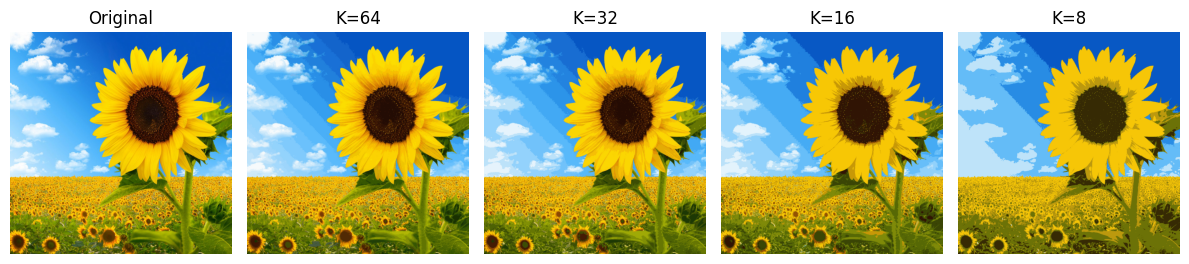

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from math import log10
from pathlib import Path
from PIL import Image
import pandas as pd

# завантяження фото
from PIL import Image
img = np.array(Image.open("flower.jpg").convert("RGB"))

# нормалізація
H, W, C = img.shape
data = img.astype(np.float32) / 255.0
pixels = data.reshape(-1, 3)

# рівні квантування
k_values = [64, 32, 16, 8]
rng = np.random.default_rng(0)
subset_size = 2000
subset_idx = rng.choice(pixels.shape[0], size=subset_size, replace=False)
pixels_subset = pixels[subset_idx]

# функції для оцінки
def mse_psnr(orig, quant):
    # якщо розміри різні — підженемо оригінал під розмір quant
    if orig.shape != quant.shape:
        h, w = quant.shape[:2]
        orig_resized = np.array(Image.fromarray(orig).resize((w, h), Image.BILINEAR))
    else:
        orig_resized = orig
    err = ((orig_resized.astype(np.float32) - quant.astype(np.float32)) ** 2).mean()
    psnr = float('inf') if err == 0 else 10 * log10((255.0 ** 2) / err)
    return err, psnr

results = []
for k in k_values:
    print(f"Processing K={k} ...")
    mbk = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=512, max_iter=20, n_init=1)
    mbk.fit(pixels_subset)
    labels = mbk.predict(pixels)
    centers = mbk.cluster_centers_
    quantized = centers[labels].reshape(H, W, 3)
    quant_uint8 = (quantized * 255).astype(np.uint8)
    mse, psnr = mse_psnr(img, quant_uint8)
    uniq = np.unique(quant_uint8.reshape(-1, 3), axis=0).shape[0]
    out_path = outdir / f"quantized_k{k}.png"
    Image.fromarray(quant_uint8).save(out_path)
    results.append({"K": k, "Unique colors": uniq, "MSE": mse, "PSNR (dB)": psnr})

#  таблтця для порівняння
df = pd.DataFrame(results)
print("\n=== Quantization Comparison ===")
print(df)

# візуалізація
plt.figure(figsize=(12, 6))
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

for i, k in enumerate(k_values):
    plt.subplot(1, 5, i + 2)
    qimg = np.array(Image.open(outdir / f"quantized_k{k}.png"))
    plt.imshow(qimg)
    plt.title(f"K={k}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Обробка та класифікація текстових даних (McDonald's Reviews)


In [29]:
import os

stopwords_path = "./english"

# читаємо файл напряму
with open(stopwords_path, "r", encoding="utf-8") as f:
    stop_words = set(line.strip() for line in f if line.strip())

# додаємо кастомні слова
stop_words |= {"mcdonald", "mcdonalds", "mcdonald's"}

print(f"✅ Успішно завантажено {len(stop_words)} стоп-слів")
print("🔹 Приклади:", list(stop_words)[:15])



✅ Успішно завантажено 201 стоп-слів
🔹 Приклади: ['there', 'these', 'those', 'has', 'too', 'to', 'between', 'had', "you're", 'their', 'll', 'from', 'during', 'your', 'before']


In [31]:
import os, re, string, random, math, warnings
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# wordcloud 
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except Exception as e:
    WORDCLOUD_AVAILABLE = False
    warnings.warn(f"WordCloud недоступний: {e}")

# ---- стоп-слова з ЛОКАЛЬНОГО файлу (офлайн) + фолбек на sklearn ----
def load_local_stopwords(candidates):
    for p in candidates:
        try:
            with open(p, "r", encoding="utf-8") as f:
                words = [ln.strip() for ln in f if ln.strip()]
            return set(words)
        except Exception:
            continue
    return None

_stopword_candidates = [
    "./english"
]

stop_words = load_local_stopwords(_stopword_candidates)
if stop_words is None:
    # фолбек, якщо локальний файл не знайдено
    stop_words = set(ENGLISH_STOP_WORDS)

# додаткові кастомні слова
stop_words |= {"mcdonald", "макдональд"}

# випадковість/параметри графіків
random.seed(42)
np.random.seed(42)
plt.rcParams["figure.figsize"] = (8, 5)


## 1) Завантаження датасету

In [32]:
file_path = "McDonald_s_Reviews.csv"

encodings_to_try = ["utf-8", "utf-8-sig", "cp1252", "windows-1252", "latin-1"]
df = None
last_err = None

for enc in encodings_to_try:
    try:
        # Відкриваємо вручну, очищаючи биті символи
        with open(file_path, "r", encoding=enc, errors="ignore") as f:
            df = pd.read_csv(f)
        print(f"Loaded successfully with encoding: {enc}")
        break
    except Exception as e:
        last_err = e

if df is None:
    raise last_err

df.head()


Loaded successfully with encoding: utf-8


,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was �����������...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


## 2) Огляд колонок і підготовка цільових міток (класи)

In [34]:
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)

# В цій таблиці є колонка 'review' (текст) і 'rating' у форматі: '1 star', '4 stars'
# Перетворимо 'rating' у числовий формат 1..5
def rating_to_int(r):
    if isinstance(r, str):
        m = re.search(r"(\d+)", r)
        if m:
            v = int(m.group(1))
            return max(1, min(5, v))
    return np.nan

df["rating_num"] = df["rating"].apply(rating_to_int)

# Підготуємо 3-класову ціль: негатив/нейтрал/позитив
def to_sentiment_class(star):
    if pd.isna(star):
        return np.nan
    star = int(star)
    if star <= 2:
        return "negative"
    elif star == 3:
        return "neutral"
    else:
        return "positive"

df["label"] = df["rating_num"].apply(to_sentiment_class)

# Залишимо лише необхідні колонки
df = df[["review", "label"]].dropna()
df = df[df["review"].astype(str).str.strip().ne("")]

print(df["label"].value_counts())
df.head()

Columns: ['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ', 'longitude', 'rating_count', 'review_time', 'review', 'rating', 'clean']
Shape: (33396, 11)
label
positive    16027
negative    12512
neutral      4809
Name: count, dtype: int64


,review,label
0,Why does it look like someone spit on my food?...,negative
1,It'd McDonalds. It is what it is as far as the...,positive
2,Made a mobile order got to the speaker and che...,negative
3,My mc. Crispy chicken sandwich was customer s...,positive
4,"I repeat my order 3 times in the drive thru, a...",negative


## 3) Функція очищення тексту

In [35]:
import re

def remove_broken_symbols(text):
    # видаляє послідовності символів '�' або подібних
    return re.sub(r"[�\ufffd]+", "", str(text))

df["review"] = df["review"].apply(remove_broken_symbols)

# Приклад функції очищення з інструкції (з невеликим додатковим триммінгом)
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"@\S+", " ", text)            # mentions
    text = re.sub(r"https*\S+", " ", text)       # urls
    text = re.sub(r"#\S+", " ", text)            # hashtags
    text = re.sub(r"\d", " ", text)              # digits
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # punctuation
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text).strip()
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df["clean"] = df["review"].apply(clean_text)
df[["review", "clean", "label"]].head(5)


,review,clean,label
0,Why does it look like someone spit on my food?...,look like someone spit food normal transaction...,negative
1,It'd McDonalds. It is what it is as far as the...,mcdonalds far food atmosphere go staff make di...,positive
2,Made a mobile order got to the speaker and che...,made mobile order got speaker checked line mov...,negative
3,My mc. Crispy chicken sandwich was customer s...,mc crispy chicken sandwich customer service qu...,positive
4,"I repeat my order 3 times in the drive thru, a...",repeat order times drive thru still manage mes...,negative


## 4) WordCloud по класах

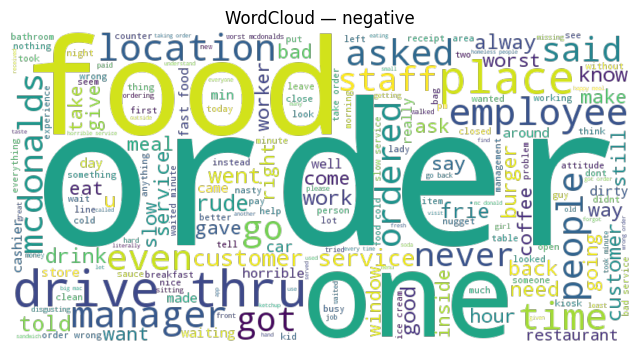

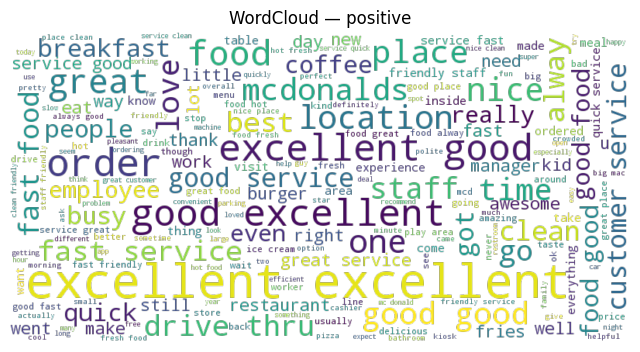

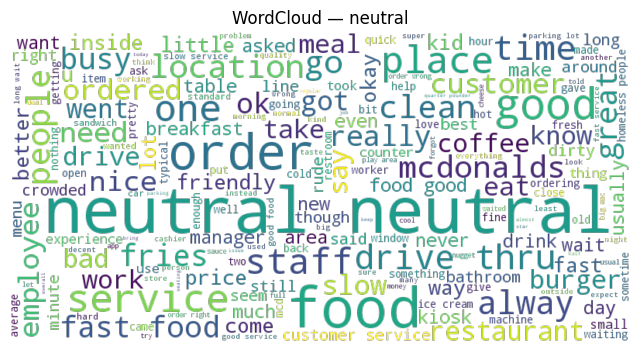

In [36]:

classes = df["label"].unique().tolist()
for cls in classes:
    subset = df[df["label"] == cls]["clean"]
    text = " ".join(subset.tolist())

    if WORDCLOUD_AVAILABLE and len(text) > 0:
        wc = WordCloud(width=800, height=400, background_color=None, mode="RGBA").generate(text)
        plt.figure()
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"WordCloud — {cls}")
        plt.show()
    else:
        # Фолбек: топ-слова барчарт
        cnt = Counter(" ".join(subset.tolist()).split())
        common = cnt.most_common(20)
        words, freqs = zip(*common) if common else ([], [])
        plt.figure()
        plt.bar(range(len(words)), freqs)
        plt.xticks(range(len(words)), words, rotation=75, ha="right")
        plt.title(f"Top tokens — {cls}")
        plt.tight_layout()
        plt.show()

## 5) Топ n-грами по класах (1–2)

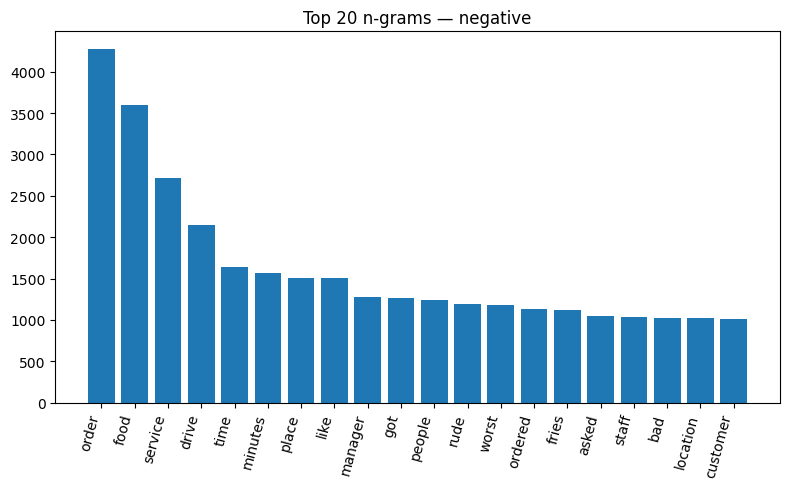

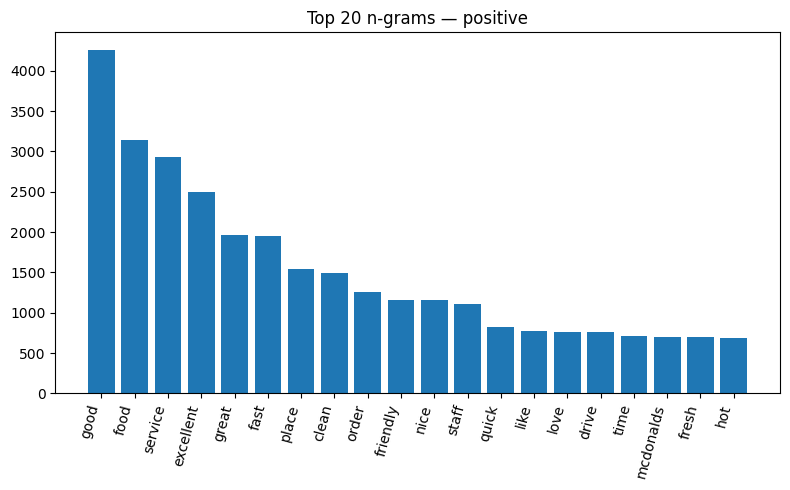

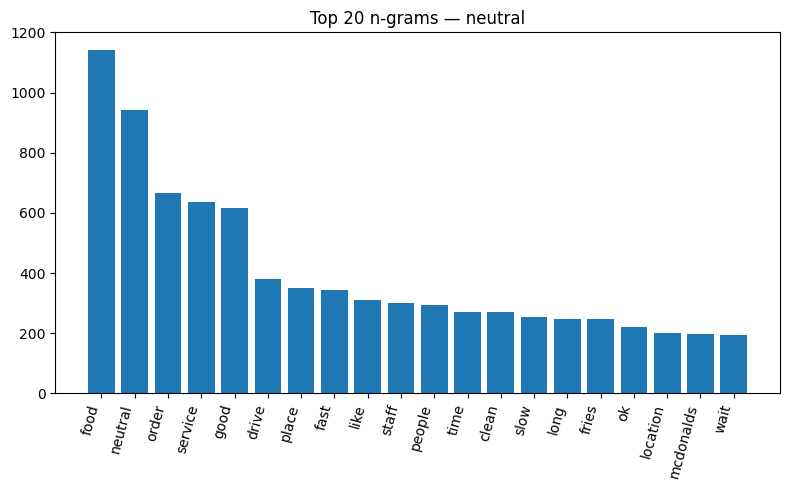

In [37]:
def top_ngrams_per_class(df, label_col="label", text_col="clean", n=20):
    for cls in df[label_col].unique():
        sub = df[df[label_col] == cls][text_col].tolist()
        vec = CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=2)
        X = vec.fit_transform(sub)
        freqs = np.asarray(X.sum(axis=0)).ravel()
        idxs = freqs.argsort()[::-1][:n]
        feats = np.array(vec.get_feature_names_out())[idxs]
        vals = freqs[idxs]

        plt.figure()
        plt.bar(range(len(feats)), vals)
        plt.xticks(range(len(feats)), feats, rotation=75, ha="right")
        plt.title(f"Top {n} n-grams — {cls}")
        plt.tight_layout()
        plt.show()

top_ngrams_per_class(df)

## 6) Train/Test розбиття

In [38]:
X = df["clean"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test), pd.Series(y_train).value_counts(normalize=True)

(26678,
 6670,
 positive    0.480583
 negative    0.375216
 neutral     0.144201
 Name: proportion, dtype: float64)

## 7) Класифікація: CountVectorizer + Logistic Regression

=== CountVectorizer + LR ===
              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      2502
     neutral       0.68      0.42      0.52       962
    positive       0.84      0.92      0.88      3206

    accuracy                           0.83      6670
   macro avg       0.79      0.74      0.75      6670
weighted avg       0.82      0.83      0.82      6670



<Figure size 800x500 with 0 Axes>

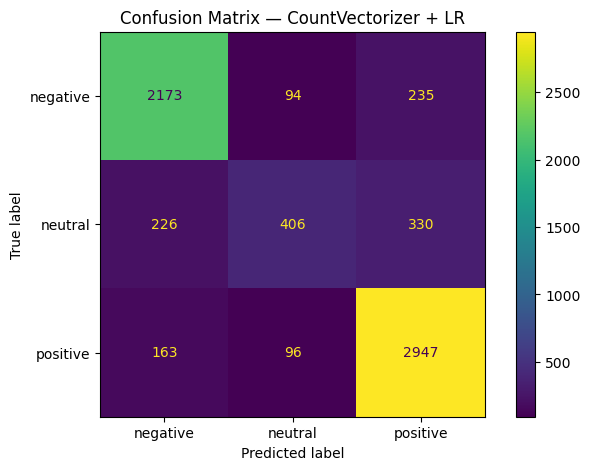

In [39]:
count_vec = CountVectorizer(stop_words="english", ngram_range=(1,2), min_df=3)
Xtr = count_vec.fit_transform(X_train)
Xte = count_vec.transform(X_test)

clf_count = LogisticRegression(max_iter=200, n_jobs=None)
clf_count.fit(Xtr, y_train)
pred_count = clf_count.predict(Xte)

print("=== CountVectorizer + LR ===")
print(classification_report(y_test, pred_count))

cm = confusion_matrix(y_test, pred_count, labels=clf_count.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_count.classes_)
plt.figure()
disp.plot(values_format='d')
plt.title("Confusion Matrix — CountVectorizer + LR")
plt.show()

## 8) Класифікація: TF-IDF + Logistic Regression

=== TF-IDF + LR ===
              precision    recall  f1-score   support

    negative       0.81      0.90      0.85      2502
     neutral       0.75      0.30      0.43       962
    positive       0.84      0.91      0.87      3206

    accuracy                           0.82      6670
   macro avg       0.80      0.70      0.72      6670
weighted avg       0.81      0.82      0.80      6670



<Figure size 800x500 with 0 Axes>

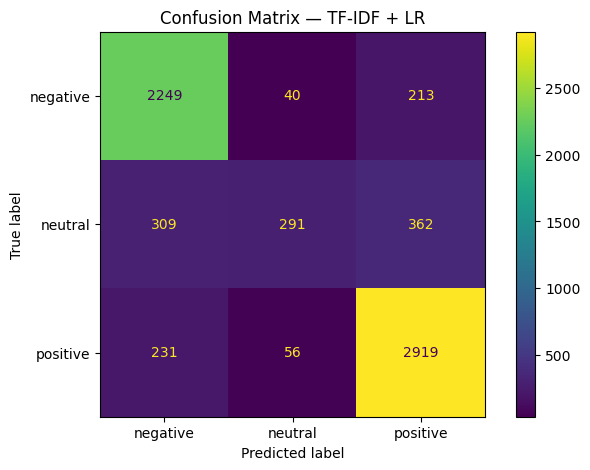

In [40]:

tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=3)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

clf_tfidf = LogisticRegression(max_iter=200, n_jobs=None)
clf_tfidf.fit(Xtr, y_train)
pred_tfidf = clf_tfidf.predict(Xte)

print("=== TF-IDF + LR ===")
print(classification_report(y_test, pred_tfidf))

cm = confusion_matrix(y_test, pred_tfidf, labels=clf_tfidf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_tfidf.classes_)
plt.figure()
disp.plot(values_format='d')
plt.title("Confusion Matrix — TF-IDF + LR")
plt.show()

## 9) Приклади помилкових класифікацій

In [41]:

# Зберемо 10 прикладів
mis_idx = np.where(pred_tfidf != y_test)[0][:10]
mis_table = pd.DataFrame({
    "text": np.array(X_test)[mis_idx],
    "true": np.array(y_test)[mis_idx],
    "pred": pred_tfidf[mis_idx]
})
mis_table


,text,true,pred
0,second time like attitude place stays clean yr...,positive,negative
1,fries fresh sandwich weirdly falling apart con...,negative,positive
2,crowded slow,neutral,negative
3,open hours,positive,negative
4,new chicken fingers great,neutral,positive
5,fast food slow really clean like trash,negative,neutral
6,universal request,positive,negative
7,god love love manager rude professional order ...,negative,positive
8,attention best staff unconcerned client general,neutral,positive
9,restroom clean utensils outside u ask get,neutral,positive
